# Getting Started

[Resource](https://www.statsmodels.org/dev/gettingstarted.html)

Load in them modules and functions:

In [4]:
import statsmodels.api as sm
import pandas
from patsy import dmatrices

`patsy` is a library for describing statistical models and building design matrices using `R`-like formulas.

## Data

We download the [Guerry dataset](https://vincentarelbundock.github.io/Rdatasets/doc/HistData/Guerry.html), a collection of historical data used in support of Antre-Michael Guerry's 1833 Essay on the Moral Statistics. We could download the file locally and then load it using `read_csv`, but let's be real... we wanna use `pandas`.

In [7]:
df = sm.datasets.get_rdataset('Guerry', 'HistData').data
df.head()

dept Region    Department  Crime_pers  Crime_prop  Literacy  Donations  \
0     1      E           Ain       28870       15890        37       5098   
1     2      N         Aisne       26226        5521        51       8901   
2     3      C        Allier       26747        7925        13      10973   
3     4      E  Basses-Alpes       12935        7289        46       2733   
4     5      E  Hautes-Alpes       17488        8174        69       6962   

   Infants  Suicides MainCity  ...  Crime_parents  Infanticide  \
0    33120     35039    2:Med  ...             71           60   
1    14572     12831    2:Med  ...              4           82   
2    17044    114121    2:Med  ...             46           42   
3    23018     14238     1:Sm  ...             70           12   
4    23076     16171     1:Sm  ...             22           23   

   Donation_clergy  Lottery  Desertion  Instruction  Prostitutes  Distance  \
0               69       41         55           46           13   218.372   
1               36       38         82           24          327    65.945   
2               76       66         16           85           34   161.927   
3               37       80         32           29            2   351.399   
4               64       79         35            7            1   320.280   

   Area  Pop1831  
0  5762   346.03  
1  7369   513.00  
2  7340   298.26  
3  6925   155.90  
4  5549   129.10  

[5 rows x 23 columns]

We select the variables of interest and look at the bottom 5 rows:

In [8]:
vars = ['Department', 'Lottery', 'Literacy', 'Wealth', 'Region']
df = df[vars]
df[-5:]

Department  Lottery  Literacy  Wealth Region
81        Vienne       40        25      68      W
82  Haute-Vienne       55        13      67      C
83        Vosges       14        62      82      E
84         Yonne       51        47      30      C
85         Corse       83        49      37    NaN

Notice that there is one missing observation in the *Region* column. We eliminate it using a `DataFrame` method provided by `pandas`:

In [12]:
df = df.dropna()
df[-5:]

Department  Lottery  Literacy  Wealth Region
80        Vendee       68        28      56      W
81        Vienne       40        25      68      W
82  Haute-Vienne       55        13      67      C
83        Vosges       14        62      82      E
84         Yonne       51        47      30      C

## Substantive motivation and model

We want to know whether literacy rates in the 86 French departments are associated with per capita wagers on the Royal Lottery in the 1820s. We need to control for the level of wealth in each department, and we also want to include a series of dummy variables on the right-hand side of our regression equation to control for unobserved heterogeneity due to regional effects. The model is estimated using OLS.

## Design matrices (endog and exog)

To fit most of the models covered by `statsmodels`, you will need to create two design matrices. The first is a matrix of endogenous variable(s) (i.e. dependent, response, regressand, etc.). The second matrix is a matrix of exogenous variable(s) (i.e. independent, predictor, regressor, etc.). The OLS coefficient estimates are calculated as usual:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mrow data-mjx-texclass="ORD">
    <mover>
      <mi>&#x3B2;</mi>
      <mo stretchy="false">^</mo>
    </mover>
  </mrow>
  <mo>=</mo>
  <mo stretchy="false">(</mo>
  <msup>
    <mi>X</mi>
    <mo data-mjx-alternate="1">&#x2032;</mo>
  </msup>
  <mi>X</mi>
  <msup>
    <mo stretchy="false">)</mo>
    <mrow data-mjx-texclass="ORD">
      <mo>&#x2212;</mo>
      <mn>1</mn>
    </mrow>
  </msup>
  <msup>
    <mi>X</mi>
    <mo data-mjx-alternate="1">&#x2032;</mo>
  </msup>
  <mi>y</mi>
</math>

where *y* is an *N* x 1 column of data on lottery wagers per capita (*Lottery*). *X* is *N* x 7 with an intercept, the *Literacy* and *Wealth* variables, and 4 region binary variables.

The `patsy` module provides a convenient function to prepare design matrices using `R`-like formulas. You can find more information [here](https://patsy.readthedocs.io/en/latest/).

We use `patsy`'s `dmatrices` function to create design matrices:

In [13]:
y, X = dmatrices('Lottery ~ Literacy + Wealth + Region', data=df, return_type='dataframe')

The resulting matrices/data frames look like this:

In [14]:
y[:3]

Lottery
0     41.0
1     38.0
2     66.0

In [15]:
X[:3]

Intercept  Region[T.E]  Region[T.N]  Region[T.S]  Region[T.W]  Literacy  \
0        1.0          1.0          0.0          0.0          0.0      37.0   
1        1.0          0.0          1.0          0.0          0.0      51.0   
2        1.0          0.0          0.0          0.0          0.0      13.0   

   Wealth  
0    73.0  
1    22.0  
2    61.0

Notice that `dmatrices` has
* split the categorical *Region* variable into a set of indicator variables.
* added a constant to the exogenous regressors matrix.
* returned `pandas` DataFrames instead of simple numpy arrays. This is useful because DataFrames allow `statsmodels` to carry-over meta-data (e.g. variable names) when reporting results.

The above behavior can of course be altered.

## Model fit and summary

Fitting a model in `statsmodels` typically involves 3 easy steps:
1. Use the model class to describe the model
1. Fit the model using a class method
1. Inspect the results using a summary method

For OLS, this is achieved by:

In [16]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           1.07e-05
Time:                        14:50:10   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      

(Is abbreviating "model" or "result" really necessary guys? Common. We're not working with C code from the 1990s)

The `res` object has many useful attributes. For example, we can extract parameter estimates and r-squared by typing:

In [17]:
res.params

Intercept      38.651655
Region[T.E]   -15.427785
Region[T.N]   -10.016961
Region[T.S]    -4.548257
Region[T.W]   -10.091276
Literacy       -0.185819
Wealth          0.451475
dtype: float64

Use `dir(res)` for a full list of attributes. This will definitely come in handy later on, so keep it in mind:

In [22]:
dir(res)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_is_nested',
 '_transform_predict_exog',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pval

## Diagnostics and specification tests

`statsmodels` allows you to conduct a range of useful regression diagnostics and specification tests. For instance, apply the Rainbow test for linearity (the null hypothesis is that the relationship is properly modelled as linear):

In [23]:
sm.stats.linear_rainbow(res)

(np.float64(0.847233997615691), np.float64(0.6997965543621644))

Admittedly, the output above isn't very verbose, but we know from reading the docstring (`print(sm.stats.linear_rainbow.__doc__)`) that the first number is n F-statistic and the second is the p-value.

`statsmodels` also provides graphics functions. For example, we can draw a plot of partial regression for a set of regressors by:

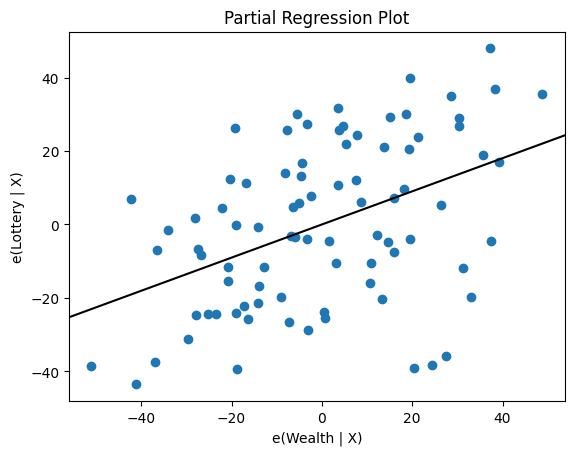

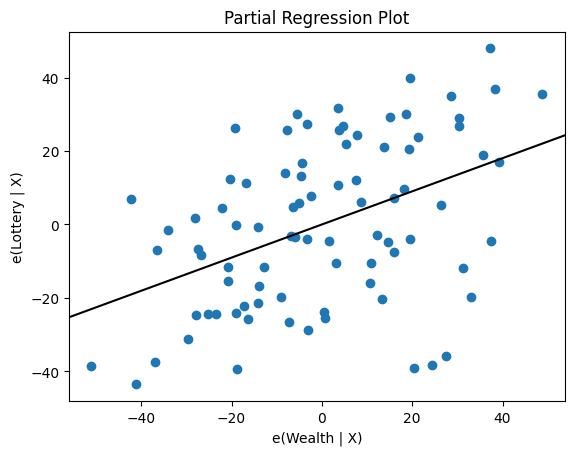

In [25]:
sm.graphics.plot_partregress('Lottery', 'Wealth', ['Region', 'Literacy'],
                             data=df, obs_labels=False)

It's shit like this right here that's why I'm learning `statsmodels`. Incredibly useful right off the bat. Let's move on to the linear regression section.